In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import sys

print("PyTorch Version:", torch.__version__)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
sys.stdout.flush()

PyTorch Version: 2.0.1
Using device: cpu


In [100]:
# Hyperparameters and config

# Path to image folder
data_dir = "data/AD_NC/train/AD-parent/"

batch_size = 128

num_epochs = 10

# Factor to reduce the width and height of the images by
dimension_reduce_factor = 4 # downsample factor of 4

# Original dimensions
original_width = 256
original_height = 240

images_input.shape: torch.Size([32, 3, 60, 64])
images_output.shape: torch.Size([32, 3, 240, 256])


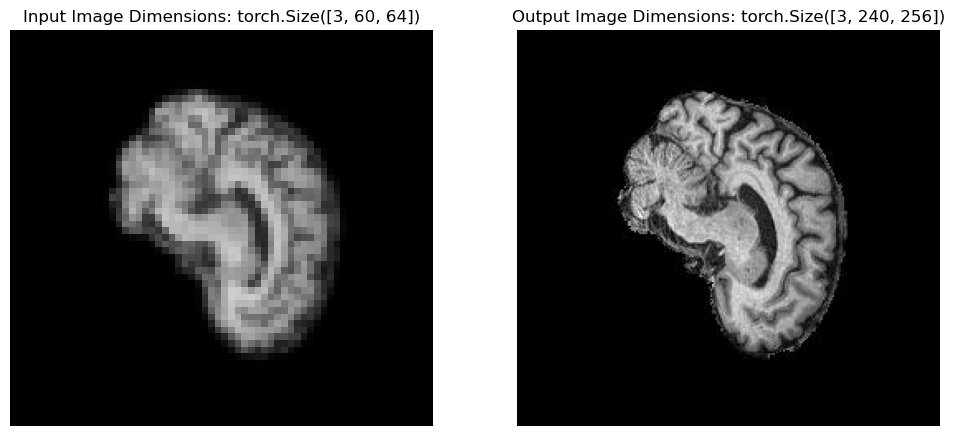

In [101]:
input_transform = transforms.Compose([
    transforms.Resize([
        original_height // dimension_reduce_factor, 
        original_width // dimension_reduce_factor
    ]),
    transforms.ToTensor(),
])

output_transform = transforms.Compose([
    transforms.ToTensor(),
])

input_dataset = ImageFolder(root=data_dir, transform=input_transform)
output_dataset = ImageFolder(root=data_dir, transform=output_transform)

# Create a data loader to iterate through the dataset
input_data_loader = DataLoader(input_dataset, batch_size=batch_size)
output_data_loader = DataLoader(output_dataset, batch_size=batch_size)

for batch_input, batch_output in zip(input_data_loader, output_data_loader):
    # Downsampled images
    images_input, _ = batch_input
    # Original images
    images_output, _ = batch_output

    print('images_input.shape:', images_input.shape)
    print('images_output.shape:', images_output.shape)
    
    # Get the dimensions of the first input image
    first_input_image = images_input[0]
    input_image_dims = first_input_image.shape  # Shape will be (3, 224, 224) for RGB images
    
    # Get the dimensions of the first output image
    first_output_image = images_output[0]
    output_image_dims = first_output_image.shape  # Shape will be (3, 224, 224) for RGB images
    
    # Display the first input image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(first_input_image.permute(1, 2, 0))  # Convert tensor to numpy format (C, H, W) -> (H, W, C)
    plt.title(f"Input Image Dimensions: {input_image_dims}")
    plt.axis('off')  # Turn off axis labels
    
    # Display the first output image
    plt.subplot(1, 2, 2)
    plt.imshow(first_output_image.permute(1, 2, 0))  # Convert tensor to numpy format (C, H, W) -> (H, W, C)
    plt.title(f"Output Image Dimensions: {output_image_dims}")
    plt.axis('off')  # Turn off axis labels
    
    plt.savefig('dimensions.png')
    
    break  # Stop after the first batch to print/display only the first pair of images

In [102]:
class SuperResolutionModel(nn.Module):
    def __init__(self, upscale_factor=2, channels=3):
        super(SuperResolutionModel, self).__init__()
        
        self.inputs = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, channels * (upscale_factor ** 2), kernel_size=3, padding=1),
        )
        
        self.outputs = nn.Sequential(
            nn.PixelShuffle(upscale_factor),
        )

    def forward(self, x):
        x = self.inputs(x)
        x = self.outputs(x)
        return x

In [103]:
# Create an instance of the super-resolution model
model = SuperResolutionModel(upscale_factor=dimension_reduce_factor)

# Test the model with an example input shape [3, 120, 128]
input_tensor = torch.randn(1, 3, original_height // dimension_reduce_factor, 
        original_width // dimension_reduce_factor)  # Batch size of 1
output_tensor = model(input_tensor)

# Check the shape of the output
print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)

Input shape: torch.Size([1, 3, 60, 64])
Output shape: torch.Size([1, 3, 240, 256])


In [104]:
# Define the loss function (MSE) and optimizer (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start = time.time()
print("Starting training...")
sys.stdout.flush()

for epoch in range(num_epochs):
    running_loss = 0.0

    i = 0
    n = len(input_data_loader)
    
    for batch_input, batch_output in zip(input_data_loader, output_data_loader):
        inputs, _ = batch_input
        expected_outputs, _ = batch_output
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, expected_outputs)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        i += 1
        if i % 50 == 0:
            print(f"Finished [{i}/{n}], running_loss: {running_loss}")
            sys.stdout.flush()

    # Print the average loss for the epoch
    average_loss = running_loss / len(input_data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {average_loss:.4f}")
    sys.stdout.flush()

end = time.time()
print(f"Training finished. Took {round((end - start) / 60, 1)} minutes")
sys.stdout.flush()

Starting training...


KeyboardInterrupt: 

In [ ]:
# Save the trained model to a file
model_path = "super_resolution_model.pth"
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to super_resolution_model.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images_input.shape: torch.Size([32, 3, 60, 64])
images_output.shape: torch.Size([32, 3, 240, 256])


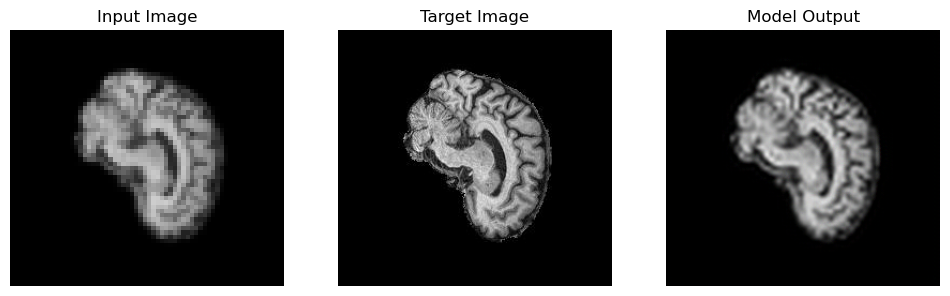

In [ ]:
with torch.no_grad():
    for batch_input, batch_output in zip(input_data_loader, output_data_loader):
        # Downsampled images
        images_input, _ = batch_input
        # Original images
        images_output, _ = batch_output

        print('images_input.shape:', images_input.shape)
        print('images_output.shape:', images_output.shape)
        
        # Get the dimensions of the first input image
        first_input_image = images_input[0]
        
        # Get the dimensions of the first output image
        first_output_image = images_output[0]

        # Actual model output
        first_model_output = model(first_input_image)
        
        # Display the first input image
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(first_input_image.permute(1, 2, 0))  # Convert tensor to numpy format (C, H, W) -> (H, W, C)
        plt.title(f"Input Image")
        plt.axis('off')  # Turn off axis labels
        
        # Display the first output image
        plt.subplot(1, 3, 2)
        plt.imshow(first_output_image.permute(1, 2, 0))  # Convert tensor to numpy format (C, H, W) -> (H, W, C)
        plt.title(f"Target Image")
        plt.axis('off')  # Turn off axis labels

        # Display the first model output
        plt.subplot(1, 3, 3)
        plt.imshow(first_model_output.permute(1, 2, 0).numpy())  # Convert tensor to numpy format (C, H, W) -> (H, W, C)
        plt.title(f"Model Output")
        plt.axis('off')  # Turn off axis labels
        
        plt.savefig('input-target-output.png')
        print("Saved example output")
        
        break  # Stop after the first batch to print/display only the first pair of images

print("Finished!")